In [9]:
import os
import numpy as np
from osgeo import gdal
import flopy
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt
# Change this line to import SpatialReference from flopy.mf6.utils.reference
from flopy.mf6.utils.reference import SpatialReference
import shapefile



In [2]:

# Define the paths to your files
folder_path = "C:\\Users\\sebas\\Documents\\UGent\\Sem 3\\Thesis\\Groundwater model\\Inputs\\Marylidia_data\\DEM\\DEM"
dem_files = ["DEM_Gondebeek.asc", "A0100_t.tif", "A0600_Ledo_Paniseliaan_Brusseliaan_Aquifer.asc", "A0700_Paniseliaan_Aquitard.asc", "A0800_Leperiaan_Aquifer.asc"]
shapefile_path = os.path.join(folder_path, "Catchment_Gondebeek.shp")

# Function to fill missing data with average of neighbouring cells
def fill(data):
    return np.where(np.isnan(data), np.nanmean(data), data)

# Function to calculate the percentage of missing data in an array
def missing_percentage(data):
    return np.count_nonzero(np.isnan(data)) / data.size * 100


In [3]:
# Part 1: Load the DEM files
layers = []
for file in dem_files:
    print(f"Processing layer {file}")
    path = os.path.join(folder_path, file)
    ds = gdal.Open(path)
    if ds is None:
        print(f"Unable to open {file}")
        continue
    data = ds.GetRasterBand(1).ReadAsArray()
    layers.append(data)

Processing layer DEM_Gondebeek.asc
Processing layer A0100_t.tif
Processing layer A0600_Ledo_Paniseliaan_Brusseliaan_Aquifer.asc
Processing layer A0700_Paniseliaan_Aquitard.asc
Processing layer A0800_Leperiaan_Aquifer.asc


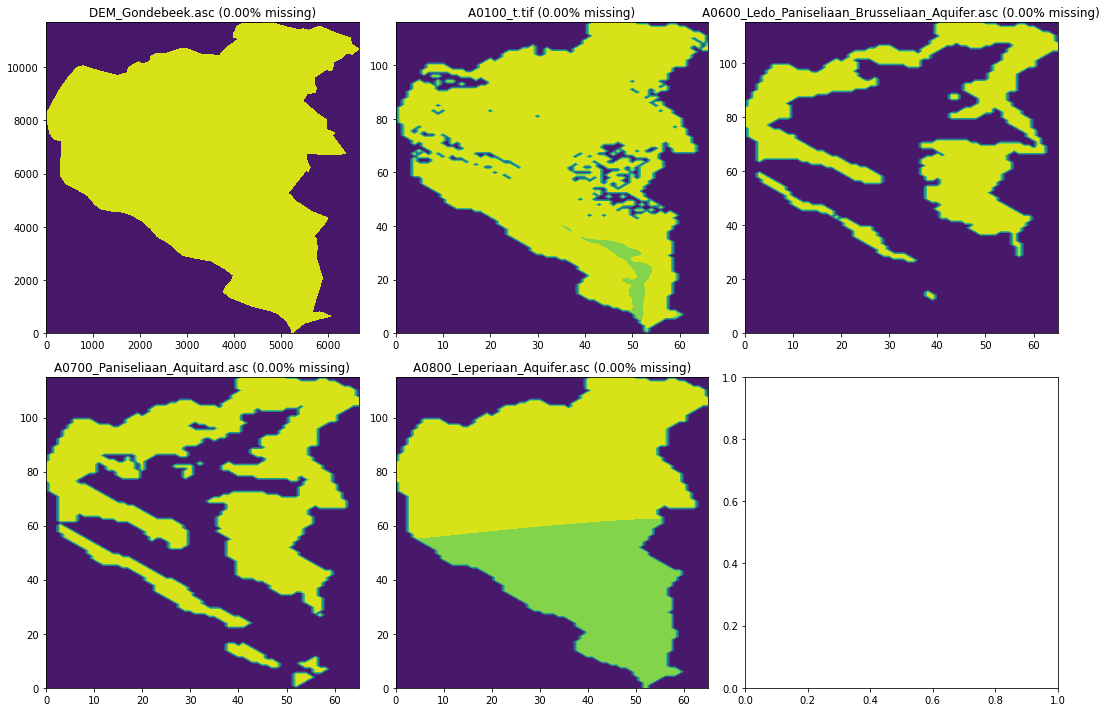

In [4]:
# Part 2: Plot the DEMs
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Loop over the layers and plot them
for i in range(len(layers)):
    # Get the row and column index for the subplot
    row = i // 3
    col = i % 3
    # Plot the layer data as a contour map
    axes[row, col].contourf(layers[i])
    # Add a title with the file name and the percentage of missing data
    axes[row, col].set_title(f"{dem_files[i]} ({missing_percentage(layers[i]):.2f}% missing)")
# Adjust the spacing between subplots
fig.tight_layout()
# Show the figure
plt.show()

In [10]:

# You will need to install the pyshp library to use this

sf = shapefile.Reader(shapefile_path)
shapes = sf.shapes()

# Set the cell size
cellsize = 100

# Set the projection information using proj4 string
proj4_str = "+proj=lcc +lat_1=51.16666723333333 +lat_2=49.8333339 +lat_0=90 +lon_0=4.367486666666666 +x_0=150000.013 +y_0=5400088.438 +ellps=intl +towgs84=-106.869,52.2978,-103.724,0.3366,-0.457,1.8422,-1.2747 +units=m +no_defs"

# Set the extent
xmin, ymin, xmax, ymax = shapes[0].bbox

# Create the SpatialReference object
sr = SpatialReference(delr=cellsize, delc=cellsize, lenuni=2, xul=xmin, yul=ymax, rotation=0, proj4_str=proj4_str)

ImportError: cannot import name 'ProjectedExtent' from 'pyproj' (C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\pyproj\__init__.py)

In [12]:
# Part 3: Intersect the layers with the spatial reference
# This will crop the layers to the model area and fill the missing data with the nearest values
# Convert the SpatialReference object to a polygon
from rasterio import features

# Get the extent of the SpatialReference object
extent = sr.bounds

# Convert the extent to a polygon
polygon = features.geometry_from_shape(extent)

# Intersect the layers with the polygon
layers = [polygon.intersection(layer) for layer in layers]


AttributeError: 'StructuredSpatialReference' object has no attribute 'bounds'

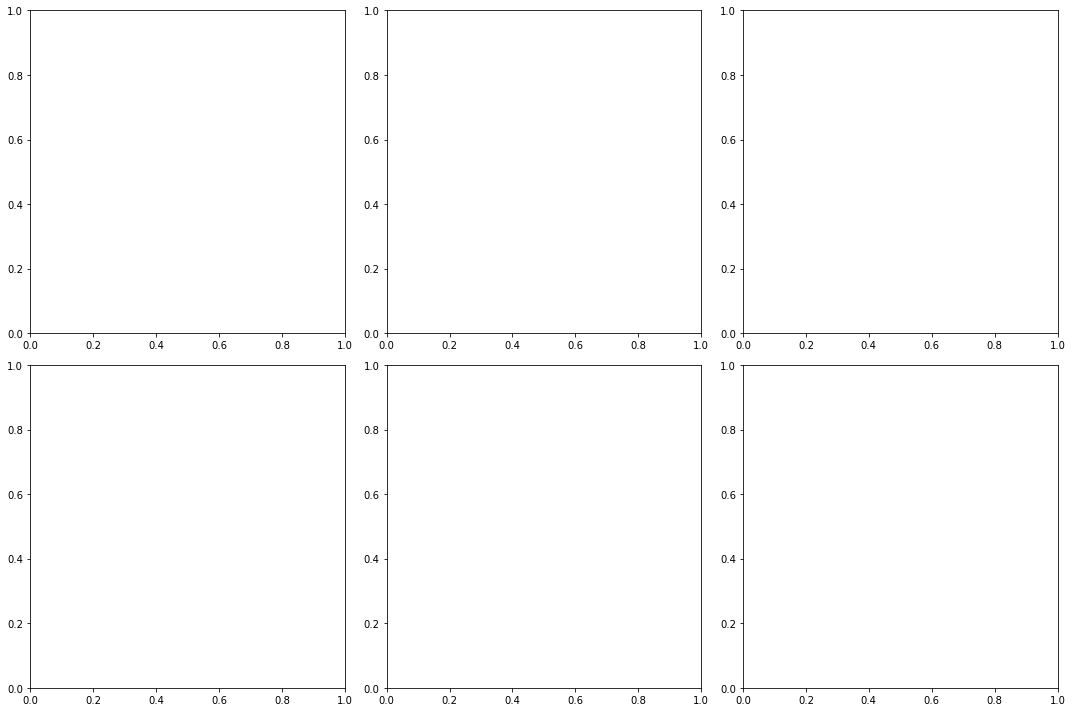

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:96: UserWarning: The program mf2005 does not exist or is not executable.
  warn(


IndexError: list index out of range

In [33]:
# Part 4: Ensure minimum thickness of 2 meters between layers
for i in range(len(layers)-1, 0, -1):
    diff = layers[i-1] - layers[i]
    layers[i-1] = np.where(diff < 2, layers[i] + 2, layers[i-1])

# Part 5: Plot the layers
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Loop over the layers and plot them
for i in range(len(layers)):
    # Get the row and column index for the subplot
    row = i // 3
    col = i % 3
    # Plot the layer data as a contour map
    axes[row, col].contourf(layers[i])
    # Add a title with the file name and the percentage of missing data
    axes[row, col].set_title(f"{dem_files[i]} ({missing_percentage(layers[i]):.2f}% missing)")
# Adjust the spacing between subplots
fig.tight_layout()
# Show the figure
plt.show()

# Part 6: Create the FloPy model
model = flopy.modflow.Modflow(modelname="Gondebeek",)  # Initialize your model here
dis = flopy.modflow.ModflowDis(model, top=layers[0], botm=layers[1:], sr=sr)